Setup
----

This assumes that you have set up your AWS credentials file. This is usually a text file ~/.aws/credentials that contains the following information:

```
[default]
aws_access_key_id = XXXXXXXXXXXXXXXX
aws_secret_access_key = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
region=us-east-1
```

You will also need to install some Python packages
```bash
pip install boto3
pip install SPARQLWrapper
```

### Get a connection to S3

In [2]:
import boto3
s3 = boto3.resource('s3')

### List buckets that we have access to

In [23]:
for bucket in s3.buckets.all():
    print(bucket.name)

dean.test
do-not-load
images-annotation-testing
lungmap-breath-data
lungmap-cchmc
lungmap-chla
lungmap-data-submissions
lungmap-discourse
lungmap-discourse-backup
lungmap-downloads
lungmap-downloads-001
lungmap-htc
lungmap-logs
lungmap-pnnl
lungmap-share
lungmap-sops
lungmap-supporting-files
lungmap-test
lungmap-uab-yale-ucsd-cmu
lungmap-web-content
sample-lists
vessietest


### Our data is in the `lungmap-breath-data` bucket

In [31]:
bucket = s3.Bucket('lungmap-breath-data')

### Peek at bucket contents

In [33]:
for i, key in enumerate(bucket.objects.all()):
    print(key.key)
    if i >= 20:
        break

LMEX0000000001/
LMEX0000000001/LMEX0000000001_wheel_graph.jpg
LMEX0000000001/downloads/
LMEX0000000001/downloads/GSExxx_series_matrix_forSingleCellLungDataV2.xlsx
LMEX0000000001/downloads/LUNGGENS_CELLTYPE.zip
LMEX0000000001/downloads/LUNGGENS_CORRELATION.zip
LMEX0000000001/downloads/LUNGGENS_EXPR.zip
LMEX0000000001/downloads/LUNGGENS_FILTERANDPEAK.zip
LMEX0000000001/downloads/LUNGGENS_IDS.zip
LMEX0000000001/downloads/LUNGGENS_SIGNATURES.zip
LMEX0000000001/downloads/LUNGGENS_SM.zip
LMEX0000000001/downloads/LUNGGENS_SUMMARY_OF_CLUSTER.zip
LMEX0000000001/downloads/LUNGGENS_TF.zip
LMEX0000000001/downloads/LUNGGENS_TTEST.zip
LMEX0000000001/downloads/LUNGGENS_USER.zip
LMEX0000000001/downloads/LUNGGENS_ZSCORE_EXPR.zip
LMEX0000000001/downloads/LUngMap_MouseE16.5_SingleCell_2014.rar
LMEX0000000001/downloads/LungMap_SingleCell_RNAseq_E16.5_CellClassificationTable_v5005_02132015.xlsx
LMEX0000000001/downloads/SamplesInfo.txt
LMEX0000000002/2015-003-012_100X_C57BL6_PND28_LMM.15.20A.1.23_HOPX_EMCN_

### We can run a SPARQL query to get metadata

In [7]:
query = """PREFIX lm: <http://ontology.lungmap.net/ontologies/expression_ontology#>
PREFIX mont: <http://ontology.lungmap.net/ontologies/mouse_anatomy#>
PREFIX owl: <http://www.w3.org/2002/07/>
PREFIX owl2: <http://www.w3.org/2002/07/owl#>
SELECT DISTINCT ?experiment_id ?experiment_type_id ?image_id ?path ?raw_file ?label ?description ?age ?age_label ?organism ?organism_label ?magnification ?platform ?strain ?date ?gender
FROM  <http://data.lungmap.net/lungmap_data>
FROM  <http://data.lungmap.net/lungmap_ontology>
WHERE {
   ?image_id lm:part_of_experiment ?experiment_id .
   ?experiment_id lm:file_name ?path .
   ?image_id lm:display_url ?raw_file .
   ?image_id lm:part_of_experiment ?experiment_id .
   OPTIONAL { ?experiment_id rdfs:comment ?description } .
   OPTIONAL { ?image_id lm:magnification ?magnification } .
   OPTIONAL { ?image_id lm:platform ?platform } .
   OPTIONAL { ?image_id lm:creation_date ?date } .
   OPTIONAL { ?experiment_id lm:gender ?gender } .
   OPTIONAL { 
      ?experiment_id lm:in_strain ?strain_id .
      BIND(REPLACE(str(?strain_id), '^.+#', '') AS ?strain) .
   } .
   ?experiment_id rdfs:label ?label .
    ?experiment_id lm:is_experiment_type ?experiment_type_id .
   ?image_id lm:in_stage ?age .
   ?age rdfs:subClassOf ?organism .
   ?organism rdfs:subClassOf lm:organism .
   ?organism rdfs:label ?organism_label .
   ?age rdfs:label ?age_label .
}
"""

In [20]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [34]:
from SPARQLWrapper import SPARQLWrapper, JSON
sparql = SPARQLWrapper("http://testdata.lungmap.net/sparql")
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for i, result in enumerate(results["results"]["bindings"]):
    pp.pprint(result)
    if i >= 3:
        break

{ 'age': { 'type': 'uri',
           'value': 'http://ontology.lungmap.net/ontologies/mouse_anatomy#LMMA0000000155'},
  'age_label': {'type': 'literal', 'value': 'E16.5'},
  'date': {'type': 'literal', 'value': '8/13/2015'},
  'experiment_id': { 'type': 'uri',
                     'value': 'http://www.w3.org/2002/07/owl#LMEX0000000671'},
  'experiment_type_id': { 'type': 'uri',
                          'value': 'http://www.w3.org/2002/07/owl#LMXT0000000004'},
  'gender': {'type': 'literal', 'value': 'male'},
  'image_id': { 'type': 'uri',
                'value': 'http://www.w3.org/2002/07/owl#LMEX0000000671_IMG_1'},
  'label': { 'type': 'literal',
             'value': ' LMXT0000000004 in Mouse strain C57Bl6'},
  'magnification': {'type': 'literal', 'value': '0.549 microns/pixel'},
  'organism': { 'type': 'uri',
                'value': 'http://www.w3.org/2002/07/owl#taxid_10090'},
  'organism_label': {'type': 'literal', 'value': 'mus musculus'},
  'path': { 'type': 'literal',
      

### Download the first 10 TIFF files at stage E16.5

In [86]:
count = 0
for i, key in enumerate(bucket.objects.all()):
    if key.key.endswith('.tif') and 'E16.5' in key.key:
        try:
            name, ext = os.path.splitext(key.key)
            filename = name.replace('.', '_') + ext
            path = os.path.split(filename)[0]
            if not os.path.exists(os.path.join('data', path)):
                os.makedirs(os.path.join('data', path))

            bucket.download_file(key.key, os.path.join('data', filename))
            print("Downloaded", os.path.join('data', filename))
            count += 1
        except Exception as e:
            print(e)
    if count >= 10:
         break

Downloaded data/LMEX0000000004/2015-004-012_20X_C57BL6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_004/2015-004-012_20X_C57BL6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_004.tif
Downloaded data/LMEX0000000004/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_001/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_001.tif
Downloaded data/LMEX0000000004/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_002/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_002.tif
Downloaded data/LMEX0000000004/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_003/2015-004-012_20X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_003.tif
Downloaded data/LMEX0000000004/2015-004-012_60X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_001/2015-004-012_60X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_001.tif
Downloaded data/LMEX0000000004/2015-004-012_60X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_002/2015-004-012_60X_C57Bl6_E16_5_LMM_14_24_4_48_HOPX_EMCN_ACTA2_002_8bit.tif
Downl

### Check that file downloaded correctly

In [91]:
import tifffile

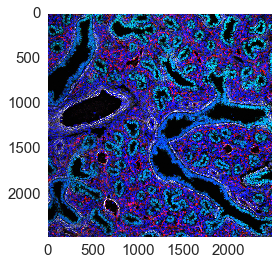

In [92]:
img = tifffile.imread('data/LMEX0000000007/2015-001-005_20X_C57Bl6_E16_5_LMM_14_57_4_51_NKX2_1_EMCN_ACTA2_001/2015-001-005_20X_C57Bl6_E16_5_LMM_14_57_4_51_NKX2_1_EMCN_ACTA2_001.tif')
plt.grid(False)
plt.imshow(img)
pass